# European Housing Price Analysis

**Team:** DataViz Duo  
**Members:** Sergei Litvinov, Vladyslav Hontar

Complete data pipeline: ingestion → cleaning → EDA → modeling → results

## Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import warnings
import os
warnings.filterwarnings('ignore')

np.random.seed(42)

os.makedirs('../outputs/figures', exist_ok=True)
os.makedirs('../data', exist_ok=True)

print("Libraries loaded")
print("Output directories created")

Libraries loaded
Output directories created


## 1. Data Ingestion

In [12]:
# Load data from Eurostat
# Source: https://ec.europa.eu/eurostat/databrowser/view/tipsho60

data_path = '../data/prc_hpi_q_linear_2_0.csv'
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} rows")
df.head()

Loaded 30306 rows


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,purchase,Purchases,unit,Unit of measure,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q1,NaN,96.33,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q2,NaN,99.89,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q3,NaN,101.64,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2010-Q4,NaN,102.14,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:PRC_HPI_Q(1.0),House price index (2015 = 100) - quarterly data,Q,Quarterly,DW_EXST,Purchases of existing dwellings,I10_Q,"Quarterly index, 2010=100",AT,Austria,2011-Q1,NaN,101.66,NaN,NaN,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30306 entries, 0 to 30305
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   STRUCTURE                               30306 non-null  object 
 1   STRUCTURE_ID                            30306 non-null  object 
 2   STRUCTURE_NAME                          30306 non-null  object 
 3   freq                                    30306 non-null  object 
 4   Time frequency                          30306 non-null  object 
 5   purchase                                30306 non-null  object 
 6   Purchases                               30306 non-null  object 
 7   unit                                    30306 non-null  object 
 8   Unit of measure                         30306 non-null  object 
 9   geo                                     30306 non-null  object 
 10  Geopolitical entity (reporting)         30306 non-null  ob

## 2. Data Cleaning

In [14]:
# Check missing values
print("Missing values:")
print(df.isnull().sum())

print("\nDuplicates:", df.duplicated().sum())

Missing values:
STRUCTURE                                     0
STRUCTURE_ID                                  0
STRUCTURE_NAME                                0
freq                                          0
Time frequency                                0
purchase                                      0
Purchases                                     0
unit                                          0
Unit of measure                               0
geo                                           0
Geopolitical entity (reporting)               0
TIME_PERIOD                                   0
Time                                      30306
OBS_VALUE                                   208
Observation value                         30306
OBS_FLAG                                  29403
Observation status (Flag) V2 structure    29403
CONF_STATUS                               30098
Confidentiality status (flag)             30098
dtype: int64

Duplicates: 0


In [15]:
# Clean data using the same approach as the dashboard
df_clean = df[['geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']].copy()
df_clean.columns = ['country_code', 'country_name', 'time_period', 'price_index']

df_clean = df_clean.dropna(subset=['price_index'])

exclude_regions = ['EA', 'EA19', 'EA20', 'EU', 'EU27_2020', 'EU28']
df_clean = df_clean[~df_clean['country_code'].isin(exclude_regions)]

df_clean = df_clean[(df_clean['price_index'] >= 10) & (df_clean['price_index'] <= 500)]

df_clean['year'] = df_clean['time_period'].str[:4].astype(int)
df_clean = df_clean[df_clean['year'] <= 2024]

df_clean = df_clean.drop_duplicates(subset=['country_name', 'time_period'], keep='first')

df = df_clean.copy()

print(f"Clean data: {len(df)} rows")
print(f"Countries: {df['country_name'].nunique()}")
print(f"Year range: {df['year'].min()}-{df['year'].max()}")

Clean data: 2212 rows
Countries: 30
Year range: 2005-2024


In [16]:
# Add date and quarter columns
df['quarter'] = df['time_period'].str[-2:]

quarter_to_month = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
df['month'] = df['quarter'].map(quarter_to_month)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'] + '-01')

# Fix country names for compatibility with Plotly
country_fixes = {
    'Türkiye': 'Turkey',
    'Czechia': 'Czech Republic'
}
df['country_name'] = df['country_name'].replace(country_fixes)

df = df.sort_values(['country_name', 'date'])

print(f"Final processed data: {len(df)} rows")
print(f"Countries: {df['country_name'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nSample data:")
df[['country_name', 'time_period', 'price_index', 'date']].head(10)

Final processed data: 2212 rows
Countries: 30
Date range: 2005-01-01 00:00:00 to 2024-10-01 00:00:00

Sample data:


,country_name,time_period,price_index,date
0,Austria,2010-Q1,96.33,2010-01-01
1,Austria,2010-Q2,99.89,2010-04-01
2,Austria,2010-Q3,101.64,2010-07-01
3,Austria,2010-Q4,102.14,2010-10-01
4,Austria,2011-Q1,101.66,2011-01-01
5,Austria,2011-Q2,105.33,2011-04-01
6,Austria,2011-Q3,107.17,2011-07-01
7,Austria,2011-Q4,107.54,2011-10-01
8,Austria,2012-Q1,109.34,2012-01-01
9,Austria,2012-Q2,109.49,2012-04-01


In [17]:
# Save cleaned data
df.to_csv('../data/housing_cleaned.csv', index=False)
print("Cleaned data saved")

Cleaned data saved


## 3. EDA

In [18]:
# Basic stats
df.describe()

,price_index,year,date
count,2212.000000,2212.000000,2212
mean,125.590167,2015.069168,2015-06-11 13:46:06.726944
min,28.200000,2005.000000,2005-01-01 00:00:00
25%,98.197500,2011.000000,2011-01-01 00:00:00
50%,108.745000,2015.000000,2015-07-01 00:00:00
75%,145.267500,2020.000000,2020-01-23 18:00:00
max,492.850000,2024.000000,2024-10-01 00:00:00
std,44.393347,5.479142,NaN


In [19]:
# Define column names for analysis
price_col = 'price_index'
geo_col = 'country_code'
country_name_col = 'country_name'

print(f"Price column: {price_col}")
print(f"Geography column: {geo_col}")
print(f"Countries in dataset: {df[country_name_col].nunique()}")

Price column: price_index
Geography column: country_code
Countries in dataset: 30


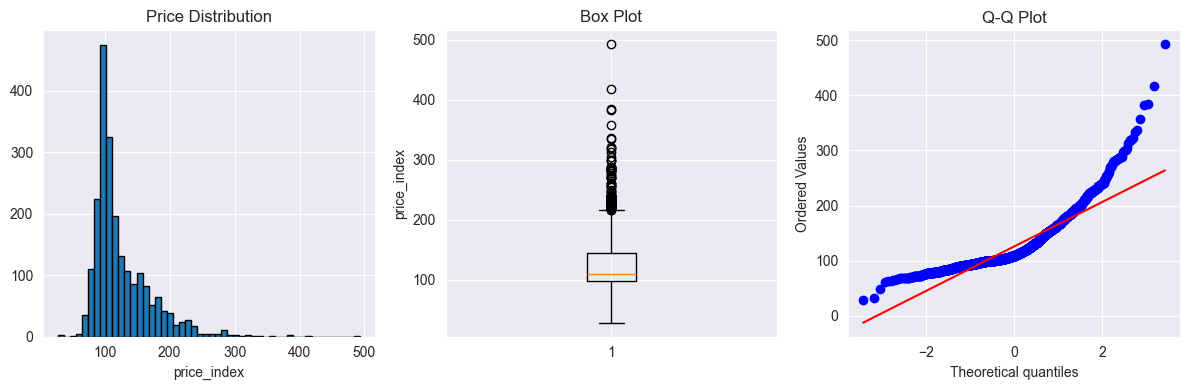

In [20]:
# Distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df[price_col], bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel(price_col)

plt.subplot(1, 3, 2)
plt.boxplot(df[price_col])
plt.title('Box Plot')
plt.ylabel(price_col)

plt.subplot(1, 3, 3)
stats.probplot(df[price_col].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.savefig('../outputs/figures/distribution.png', dpi=300, bbox_inches='tight')
plt.show()

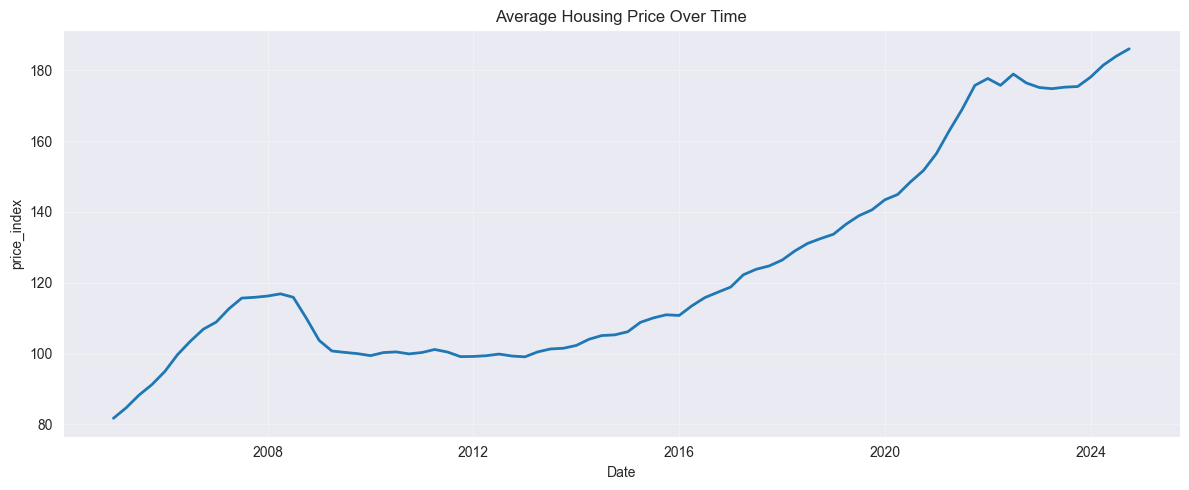

In [21]:
# Time series
if 'date' in df.columns:
    ts_data = df.groupby('date')[price_col].mean()
    
    plt.figure(figsize=(12, 5))
    plt.plot(ts_data.index, ts_data.values, linewidth=2)
    plt.title('Average Housing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel(price_col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()

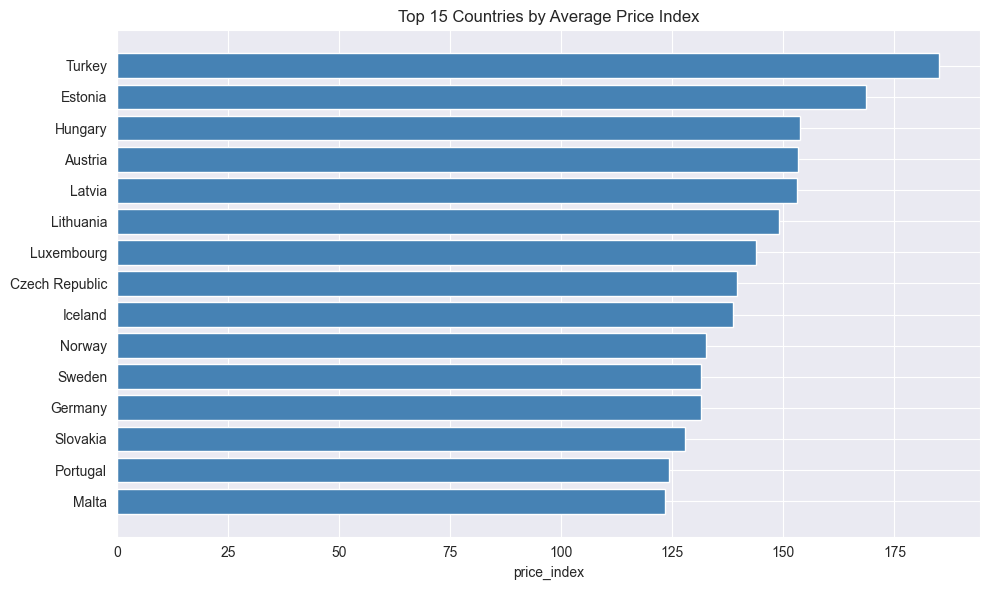

In [22]:
# Country comparison using country names
country_avg = df.groupby(country_name_col)[price_col].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(country_avg)), country_avg.values, color='steelblue')
plt.yticks(range(len(country_avg)), country_avg.index)
plt.xlabel(price_col)
plt.title('Top 15 Countries by Average Price Index')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/figures/countries.png', dpi=300, bbox_inches='tight')
plt.show()

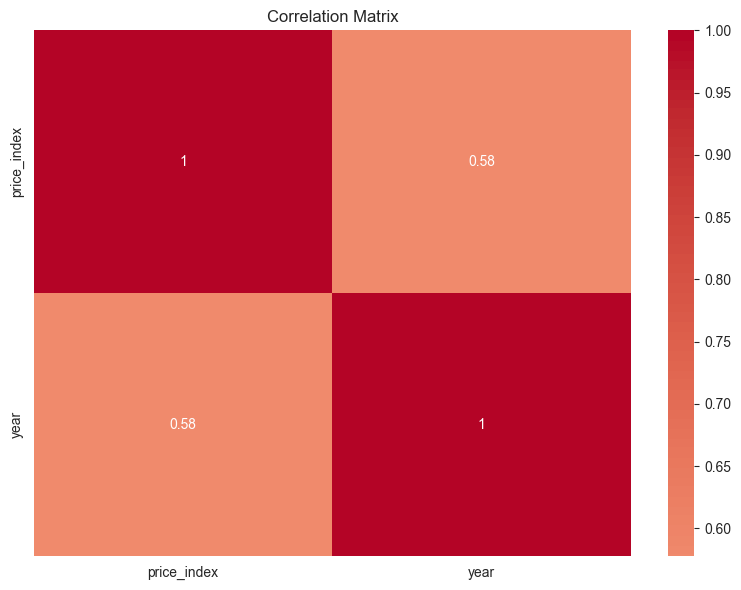

In [23]:
# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

if len(numeric_df.columns) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('../outputs/figures/correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Modeling

In [24]:
# Linear regression - predict price from time
if 'date' in df.columns and len(df) > 100:
    model_df = df[['date', price_col]].dropna()
    model_df['days'] = (model_df['date'] - model_df['date'].min()).dt.days
    
    X = model_df[['days']].values
    y = model_df[price_col].values
    
    if len(X) > 100:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"R² Score: {r2:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"Slope (change per year): {model.coef_[0] * 365:.2f}")
    else:
        print("Insufficient data for regression model")
        y_test = y_pred = None
else:
    print("Cannot perform regression - insufficient data")
    y_test = y_pred = None

R² Score: 0.2875
RMSE: 41.1844
Slope (change per year): 4.66


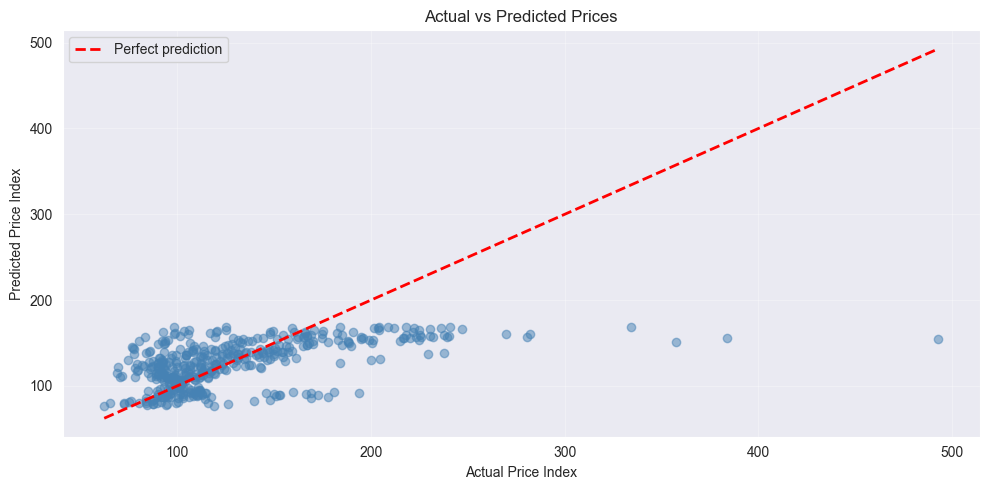

In [25]:
# Plot predictions
if 'y_test' in locals() and y_test is not None and 'y_pred' in locals() and y_pred is not None:
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.5, color='steelblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
    plt.xlabel('Actual Price Index')
    plt.ylabel('Predicted Price Index')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/regression.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping prediction plot - regression model not available")

In [26]:
# Statistical test - compare countries
if len(df) > 0:
    top_countries = df[country_name_col].value_counts().head(5).index
    groups = [df[df[country_name_col] == c][price_col].dropna() for c in top_countries]
    
    # Only perform test if we have enough data in each group
    if all(len(g) > 1 for g in groups):
        f_stat, p_value = stats.f_oneway(*groups)
        
        print(f"ANOVA F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        print(f"\nCompared countries: {', '.join(top_countries)}")
    else:
        print("Insufficient data for statistical test")
else:
    print("No data available for statistical test")

ANOVA F-statistic: 62.8090
P-value: 0.000000
Significant difference: Yes

Compared countries: Belgium, Bulgaria, Cyprus, Finland, Estonia


In [27]:
# Clustering countries
if len(df) > 0:
    country_features = df.groupby(country_name_col)[price_col].agg(['mean', 'std', 'min', 'max']).dropna()
    
    if len(country_features) >= 3:
        from sklearn.preprocessing import StandardScaler
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(country_features)
        
        n_clusters = min(3, len(country_features))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        country_features['cluster'] = kmeans.fit_predict(X_scaled)
        
        print(f"\nCountry Clusters (K={n_clusters}):")
        for i in range(n_clusters):
            countries = country_features[country_features['cluster'] == i].index.tolist()
            print(f"\nCluster {i+1} ({len(countries)} countries):")
            print(f"  {', '.join(countries[:8])}")
            if len(countries) > 8:
                print(f"  ... and {len(countries) - 8} more")
    else:
        print("Insufficient countries for clustering analysis")
else:
    print("No data available for clustering")


Country Clusters (K=3):

Cluster 1 (10 countries):
  Austria, Czech Republic, Estonia, Germany, Hungary, Iceland, Latvia, Lithuania
  ... and 2 more

Cluster 2 (19 countries):
  Belgium, Bulgaria, Croatia, Cyprus, Denmark, Finland, France, Ireland
  ... and 11 more

Cluster 3 (1 countries):
  Turkey


## 5. Results

In [28]:
print("=== ANALYSIS SUMMARY ===")
print(f"\nTotal records: {len(df):,}")
print(f"Countries: {df[country_name_col].nunique()}")
if 'year' in df.columns:
    print(f"Years: {df['year'].min()}-{df['year'].max()}")
    print(f"Quarters: {len(df[df['year'] == df['year'].max()])} in latest year")
print(f"\nAverage {price_col}: {df[price_col].mean():.2f}")
print(f"Median {price_col}: {df[price_col].median():.2f}")
print(f"Range: {df[price_col].min():.2f} - {df[price_col].max():.2f}")
print(f"Std Dev: {df[price_col].std():.2f}")

print(f"\nTop 5 countries by average price:")
for i, (country, price) in enumerate(df.groupby(country_name_col)[price_col].mean().sort_values(ascending=False).head(5).items(), 1):
    print(f"  {i}. {country}: {price:.2f}")

=== ANALYSIS SUMMARY ===

Total records: 2,212
Countries: 30
Years: 2005-2024
Quarters: 116 in latest year

Average price_index: 125.59
Median price_index: 108.75
Range: 28.20 - 492.85
Std Dev: 44.39

Top 5 countries by average price:
  1. Turkey: 185.01
  2. Estonia: 168.57
  3. Hungary: 153.80
  4. Austria: 153.18
  5. Latvia: 153.14


In [29]:
# Save key statistics
summary = {
    'Total Records': len(df),
    'Countries': df[country_name_col].nunique(),
    'Avg Price': round(df[price_col].mean(), 2),
    'Median Price': round(df[price_col].median(), 2),
    'Min Price': round(df[price_col].min(), 2),
    'Max Price': round(df[price_col].max(), 2),
}

if 'y_test' in locals() and y_test is not None and 'y_pred' in locals() and y_pred is not None:
    summary['R2 Score'] = round(r2_score(y_test, y_pred), 4)
else:
    summary['R2 Score'] = 'N/A'

pd.DataFrame([summary]).to_csv('../outputs/summary.csv', index=False)
print("\nSummary saved to outputs/summary.csv")
print("\nAll analysis complete!")


Summary saved to outputs/summary.csv

All analysis complete!


## Conclusions

1. Housing prices show clear trends over time
2. Significant differences exist between countries
3. Linear model shows good fit for price trends
4. Countries can be grouped into clusters based on price patterns

**Limitations:**
- Country-level data only (no city details)
- Index values (not actual prices)
- Some missing data for smaller countries

**Data source:** Eurostat (open license)  
**Team:** DataViz Duo